# Hands-on Session 4: Reinforcement Learning

## Objectives
* To train a Deep Reinforcement Learning model (DQN) to solve the Gridworld game, in which a player collects objects in a room.
* To build a solid understanding of the components  of  DQNs.
* To practice optimization techniques for training deep neural networks efficiently.  

## Problem description

We aim to train an agent to collect an object in a room. The room specifications are decided by the user (room dimensions and locations of inner walls). The agent is initially placed at a fixed or random starting location in the room. At each time step, the agent takes one of four actions (move north, east, south or west). Every time the agent bumps into a wall, it receives a negative reward of $-1$. When the agent finds the goal object, it receives a positive reward of $10$ and the game terminates. After 100 steps, if the agent has not reached the goal yet, the game terminates.   

## Getting started 

We provide you with the code for buiding the Gridwold game environment. The relevent Python files can be found in the home folder in `Prefabs/`, `game.py`, and `build_game.py`.

Below you can find an example of how to build and start a game. The objective of this exercise will be to build a Q-Network to learn the optimal policy.

### Import libraries
This hands-on exercice requires the following standard Python libraries: numpy, time, matplotlib, os, random scipy as well as tensorflow.

In [1]:
from __future__ import division

%matplotlib notebook
import numpy as np
import build_game
from Prefabs import static
from Prefabs.player import NormalPlayer
from Prefabs.interactive import GoldObj
import time
import matplotlib.pyplot as plt

import os
import random
import scipy.misc
import tensorflow as tf
import tensorflow.contrib.slim as slim

%matplotlib inline


### Design the GridWorld Environment 

To design a GridWorld environment with fixed initial state, we use the function `build_game.build_game()`. It requires to give as input a "drawing" of the initial state as well as some object information. In the example below, the walls are drawn with the character '#', the player with character 'P' and the target object with character 'I'. 

In [2]:
ascii_art_world = ['######',
                   '# I  #',
                   '#    #',
                   '#  P #',
                   '#    #',
                   '######']

obj_information= {
    'P': NormalPlayer((0, 0, 255)),
    '#': static.Static((0, 0, 0)),
    'I': GoldObj((0, 255, 255))
}

obj_size = 2

env = build_game.build_game(ascii_art_world, obj_information, obj_size)

### Define the Hyperparameters of the Q-Network and the Training

In [3]:
batch_size = 32 # How many experiences to use for each training step.
update_freq = 4 # How often to perform a training step.
y = .99 # Discount factor on the target Q-values
startE = 1 # Starting chance of random action
endE = 0.1 # Final chance of random action
anneling_steps = 3000 # How many steps of training to reduce startE to endE.
num_episodes = 1000 # How many episodes of game environment to train network with.
pre_train_steps = 500 # How many steps of random actions before training begins.
model_path = "./models4/dqn" # The path to save our model to.
summary_path = './summaries4/dqn' # The path to save summary statistics to.
h_size = 256 # The number of units in the hidden layer.
learning_rate = 1e-3 # Agent Learning Rate
load_model = False # Whether to load a saved model.
train_model = True # Whether to train the model

### Implementing the network itself

The model we will build to approximate the Q value function is dueling DQN, i.e. a neural network consisting of two convlutional layers and some fully connected layers. It is depicted below.

![alt text](Qnet.jpeg "Q-Network")

The in the cell below implements the major parts of the Qnetwork. Within the code, you will find some missing parts, your task is to implement them. They are summarised here (it might be useful to have a look at the last slides of today's lecture to have an idea of the mathematical steps that you need to implement):

**Task 1:** Write the code to compute the Q-values (output of the network) given the advantage and the value function.  
**Task 2:** Write the code to predict the best action given the Q-values.  
**Task 3:** Write the code to compute the TD error.


In [4]:
class Qnetwork():
    def __init__(self ,h_size, num_actions, lr, scope):
        with tf.variable_scope(scope):
            # The network recieves a frame from the game, flattened into an array.
            # It then resizes it and processes it through two convolutional layers.
            self.observation_input =  tf.placeholder(shape=[None, 12, 12, 3],dtype=tf.float32)
            self.conv1 = slim.conv2d(self.observation_input, 64, 
                                     kernel_size=[3,3], stride=[2,2], 
                                     biases_initializer=None,
                                     activation_fn=tf.nn.elu)
            self.conv2 = slim.conv2d(self.conv1, 64, 
                                     kernel_size=[3,3], 
                                     stride=[2,2], 
                                     biases_initializer=None,
                                     activation_fn=tf.nn.elu)

            # We take the output from the final convolutional layer 
            # and split it into separate advantage and value streams.
            self.hidden = slim.fully_connected(slim.flatten(self.conv2), 
                                               h_size, activation_fn=tf.nn.elu)
            self.advantage = slim.fully_connected(self.hidden, num_actions, activation_fn=None,
                                                  biases_initializer=None)
            self.value = slim.fully_connected(self.hidden, 1, activation_fn=None,
                                                  biases_initializer=None)

            # Task 1: Combine advantage and vaule together to get the final Q-values.
            self.q_out = self.value + tf.subtract(self.advantage, 
                                                  tf.reduce_mean(self.advantage,axis=1, keep_dims=True))
            # Task 2: Select the best action given q_out
            self.predict = tf.argmax(self.q_out,1)

            # Below we obtain the loss by taking the sum of squares difference 
            # between the target and prediction Q values.
            self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
            self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
            self.actions_onehot = tf.one_hot(self.actions,num_actions,dtype=tf.float32)

            self.Q = tf.reduce_sum(tf.multiply(self.q_out, self.actions_onehot), axis=1)

            # Task 3: Compute the TD error
            self.td_error = tf.square(self.targetQ - self.Q)
            self.loss = tf.reduce_mean(self.td_error)
            self.trainer = tf.train.AdamOptimizer(learning_rate=lr)
            self.update = self.trainer.minimize(self.loss)

### Experience Replay 

The code below implements the class for storing past experiences and for sampling from them.  

In [5]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

### Updating the Target Network

The code below implements the function that updates the parameters of a network (the target network) with the parameters of another network (the main network). 

In [6]:
def update_target_graph(from_scope, to_scope):
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_scope)

    op_holder = []
    for from_var,to_var in zip(from_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

### Training the Q-Network

You have now completed your first deep RL implementation! We can now start training the network. The code below implements the main training parts, but is missing some key elements. Similarly as before, fill in the blanks.

**Task 4:** Implement the epsilon-greedy strategy. In other words, write the code to select a random action with probability epsilon, otherwise select the best action given the Q network.  
**Task 5:** Write the code to retrieve a batch of random samples from the buffer (hint: you can use the functions defined in the `experience_buffer` class).  
**Task 6:** Write the code to compute the episode's reward (cumulative steps rewards).  
**Task 7:** Write the code to save each episode's experiences into the main buffer.

You can now run the cell to start the training. You will see the evolution of the agent's policy in the interactive plot below the cell while the code is being executed.

<IPython.core.display.Javascript object>


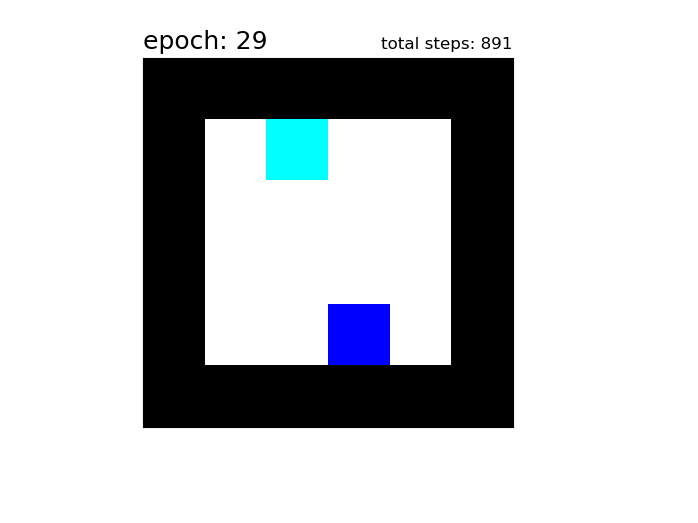

/media/afroditi/STORAGE/PythonCode/DSTL/DSTL_LABS_SEPT_2019 /Day4/game.py:402: UserWarning: The game hasn't terminated for reset
  warnings.warn("The game hasn't terminated for reset")


Mean Reward: 0.8181818181818182
Mean Reward: 2.3333333333333335


KeyboardInterrupt: 

In [7]:
%matplotlib notebook

#initialise the graph and settings
fig = plt.figure()
ax = fig.add_subplot(111)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.ion()

ax.imshow(env.render_map())
ax.set_title('reward: %.2f' % 0., loc='right', fontsize=18)
ax.set_title('epoch: %d' % 0, loc='left', fontsize=18)
# ax.set_title('total steps: %d' % 0, loc='right')
fig.show()
fig.canvas.draw()

action_space_size = 4
tf.reset_default_graph()
mainQN = Qnetwork(h_size, action_space_size, learning_rate, "main")
targetQN = Qnetwork(h_size, action_space_size, learning_rate, "target")

init = tf.global_variables_initializer()

if not os.path.exists(summary_path):
    os.makedirs(summary_path)
    
if not os.path.exists(model_path):
    os.makedirs(model_path)

saver = tf.train.Saver()

trainables = tf.trainable_variables()

update_target_ops = update_target_graph("main", "target")

myBuffer = experience_buffer()

# Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

# Create lists to contain total rewards and steps per episode
episode_lengths = []
episode_rewards = []
losses = []
total_steps = 0

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(model_path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        time.sleep(0.3)
        episodeBuffer = experience_buffer()
        observations = env.reset()
        observation = np.concatenate([observations, observations, observations], axis=2)
        done = False
        episode_reward = 0
        episode_steps = 0
        
        ax.clear()
        ax.imshow(env.render_map())
        ax.set_title('reward: %.2f' % episode_reward, loc='right', fontsize=18)
        ax.set_title('epoch: %d' % i, loc='left', fontsize=18)
       # ax.set_title('total steps: %d' % total_steps, loc='right')
        fig.canvas.draw()
        
        while not done:
            episode_steps+=1
            # Choose an action by greedily (with e chance of random action) from the Q-network
            if (np.random.rand(1) < e or total_steps < pre_train_steps) and train_model:
                action = np.random.randint(0,action_space_size)
            else:
                action = sess.run(mainQN.predict, 
                                  feed_dict={mainQN.observation_input:[observation]})[0]
            if not train_model and np.random.rand(1) < 0.1:
                action = np.random.randint(0,action_space_size)
            observations_1, reward, done = env.step(action)
                                      
            observation_1 = observation[:, :, 1:]
            observation_1 = np.concatenate([observation_1, observations_1], axis=2)
            total_steps += 1
            
            # Save the experience to our episode buffer.
            episodeBuffer.add(np.reshape(np.array([observation,action,reward,observation_1,done]),[1,5])) 
            
            if total_steps > pre_train_steps and train_model:
                if total_steps % 1000 == 0:
                    sess.run(update_target_ops)
                
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    # Get a random batch of experiences.
                    trainBatch = myBuffer.sample(batch_size) 
                    # Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict, 
                                  feed_dict={mainQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
                    Q2 = sess.run(targetQN.q_out, 
                                  feed_dict={targetQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    # Update the network with our target values.
                    _, q_loss = sess.run([mainQN.update, mainQN.loss],
                        feed_dict={mainQN.observation_input:np.stack(trainBatch[:,0], axis=0),
                                   mainQN.targetQ:targetQ, 
                                   mainQN.actions:trainBatch[:,1]})
                    losses.append(q_loss)
            episode_reward += reward
            observation = observation_1
            
            ax.clear()
            ax.imshow(env.render_map())
            ax.set_title('reward: %.2f' % episode_reward, loc='right', fontsize=18)
            ax.set_title('epoch: %d' % i, loc='left', fontsize=18)
           # ax.set_title('total steps: %d' % total_steps, loc='right')
            fig.canvas.draw()
                    
        myBuffer.add(episodeBuffer.buffer)
        episode_lengths.append(episode_steps)
        episode_rewards.append(episode_reward)
        # Periodically save the model 
        if i % 1000 == 0 and i != 0:
            saver.save(sess, model_path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if i % 10 == 0 and i != 0:
            print ("Mean Reward: {}".format(np.mean(episode_rewards[-50:])))

## Analysis

Observe the agent improving its policy over time. After a few training epochs, the agent should be making less mistakes (such as bumping into walls) and should go more directly towards the goal. Once the training is completed, run the cell below. It will plot the cumulative reward of each training espisode over time. 

In [ ]:
%matplotlib inline
plt.plot(episode_rewards)
plt.ylabel('Episode cumulative reward')
plt.xlabel('Number of training episodes')
plt.show()



### Changing the Game Settings
We are now intersted in understating if the same network is able to perform well in different environement settings. We consider the same game, but with a random initialisation. In other words, at each new episode, both the player and the goal object are placed at a new random location. 

Think about the following:
* How does it affect the state space? The action space?
* How do we expect the network to behave? 

**Task 7**: Go back to the designing the GridWorld cell and do the necessary changes in the code to build a random GridWorld game.  
Hint: The function 
```python
build_game.build_random_game(grid_size, obj_information, obj_size)
``` 
returns a grid word environement of dimentions grid_size X grid_size.  
**Task 8**: Run the training again. Run the next cell and observe the evolution of the training now compared to the previous settings.  


In [ ]:
%matplotlib inline
plt.plot(episode_rewards)
plt.ylabel('Episode cumulative reward')
plt.xlabel('Number of training episodes')
plt.show()

**Task 9**: How can we speed up the training? (Hint: did the agent explore the environement enough?)  

### Changing the Q-Network Settings
We now investigate how the network's architecture affects the learnt policy. 

**Task 10**: In the QNetwork class implementation, remove one of the convolutional layers. Run the training again and observe the changes in how the training evolves over time.  



In [ ]:
%matplotlib inline
plt.plot(episode_rewards)
plt.ylabel('Episode cumulative reward')
plt.xlabel('Number of training episodes')
plt.show()


**Task 11**: In additon of the number of layers, there are many other network parameters that are pre-defined. 
For each of the following parameters, change their value and train the network again. Each time, observe how it affects the performance of the learning  (i.e., plot the cumulative reward vs time).   
• Number of hidden units in the fully connected layers.  
• Type of activation function at the output of the convlutional layers (currently it is the exponential linear given by `tf.nn.elu`)


In [ ]:
%matplotlib inline
plt.plot(episode_rewards)
plt.ylabel('Episode cumulative reward')
plt.xlabel('Number of training episodes')
plt.show()


### Changing the Training Settings
**Task 12**: The training itself also requires some predefined parameters such as the value of epsilon for performing espilon-greedy action selection, the discount factor and experience replay. For each of the following parameters, change their value and train the network again. Each time, observe how it affects the performance of the learning.   
* The anneling step; how quickly/slowly to decay the espilon parameter. This relates to the exploration/exploitation tradeoff.  
* The batch size; how many experiences to use for each training step.  
* Training without experience replay. 


In [ ]:
%matplotlib inline
plt.plot(episode_rewards)
plt.ylabel('Episode cumulative reward')
plt.xlabel('Number of training episodes')
plt.show()